# OTalign 200 cell lines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.decomposition import PCA
import scanpy as sc
import math

import pandas as pd

from matplotlib import animation, rc
from IPython.display import HTML

import sys
DATA_PATH = '/home/risitop/OneDrive/Documents/PHD/y1/data/'
sys.path.append(DATA_PATH)

In [31]:
import ot

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_discrepancy_nn(Xs, Xt, n_neighbors=3):
    nns = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(Xs).kneighbors_graph(Xs).toarray()
    nnt = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(Xt).kneighbors_graph(Xt).toarray()
    D = nnt - nns
    return np.linalg.norm(D, axis=0).astype(float)/n_neighbors

def cosine_pairwise_distance(X):        
    n = np.linalg.norm(X, axis=1)
    X = np.dot(np.diag(1/n), X)
    return cdist(X, X)

def compute_discrepancy_d(Xs, Xt):
    Ds = cosine_pairwise_distance(Xs)
    Dt = cosine_pairwise_distance(Xt)
    D = Ds - Dt
    return 1 / np.linalg.norm(D, axis=1)
    
def OT_raw(Xs, Yt, alph=1, bet=1):
    w_x, w_y = np.ones((len(Xs),))/len(Xs), np.ones((len(Yt),))/len(Yt)
    M = ot.dist(Xs, Yt)**alph
    M /= M.max()
    Gs = ot.sinkhorn(w_x, w_y, M, 1e-3)
    return np.dot(np.diag(1/w_x), np.dot(Gs, Yt))

def OT_regularized_nn(Xs, Yt, alph=1, bet=1, n_neighbors=3):
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = 1 - compute_discrepancy_nn(Xs, Xt, n_neighbors)
    return np.dot(np.diag(lambdas), Xt - Xs) + Xs

def OT_regularized_d(Xs, Yt, alph=1, bet=1):
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = 1 - compute_discrepancy_d(Xs, Xt)
    return np.dot(np.diag(lambdas), Xt - Xs) + Xs

def OT_oob(Xs, Yt, alph=1, bet=1, n_neighbors=3):
    n = len(Xs)
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = compute_discrepancy_nn(Xs, Xt, n_neighbors)
    return np.hstack((Xt, np.reshape(lambdas, (n, 1))))

In [3]:
plt.style.use('dark_background')

In [4]:
df = pd.read_csv(DATA_PATH + "sc200CL_pp_ICs.csv")
df

,NAME,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,Cell_line
0,AAACCTGAGACATAAC-1-18,-99.818459,173.741521,-232.018942,-74.847414,151.583701,363.586113,-197.318604,-46.907309,-108.866817,11.721186,-115.730541,-125.724647,85.085009,-95.410855,135.250149,NCIH2126_LUNG
1,AACGTTGTCACCCGAG-1-18,-365.105165,502.862521,401.712867,-25.057762,686.153472,178.811548,-589.206868,185.971840,-253.509304,173.024641,-137.729830,-289.861704,183.012135,-10.529489,226.816979,NCIH2126_LUNG
2,AACTGGTAGACACGAC-1-18,-121.848356,-116.513696,143.411212,-69.716659,158.548603,381.552717,-135.670452,168.072098,-67.698316,-96.353968,-71.127793,-161.689837,-19.864331,-11.386509,137.387300,NCIH2126_LUNG
3,AACTGGTAGGGCTTGA-1-18,-205.194457,48.365893,487.468206,-72.629798,126.248179,349.767986,-184.985559,159.171509,-100.902060,183.654984,-16.949020,-66.664930,20.494175,-79.321458,95.879485,NCIH2126_LUNG
4,AACTGGTAGTACTTGC-1-18,-57.192036,124.393691,400.282657,-95.015763,-128.924317,401.022324,-11.758874,84.150622,-10.870507,199.540520,-107.670113,-115.871194,-85.385208,14.079377,164.104327,NCIH2126_LUNG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42357,c4722,209.043644,-686.418826,-750.923579,91.197807,-244.499505,847.515693,132.003789,-635.315574,-91.357654,-44.849527,106.931842,203.831756,-173.962918,71.156449,-266.205545,JHU006_UPPER_AERODIGESTIVE_TRACT
42358,c4724,-716.185216,518.196015,238.907594,-477.522653,383.340031,1077.989769,-984.701063,94.457032,-554.662558,37.480113,-290.708843,-218.883936,-80.708291,54.135597,334.807820,JHU006_UPPER_AERODIGESTIVE_TRACT
42359,c4731,-568.244675,234.296298,245.846414,-322.322384,397.972779,605.576656,-694.428346,87.662286,-441.773382,141.604703,-252.337115,-105.481505,18.279106,104.484179,158.050752,JHU006_UPPER_AERODIGESTIVE_TRACT
42360,c4735,67.672370,161.105422,51.184793,-4.890339,-82.172534,-75.655853,76.543314,2.412750,88.917357,-6.469208,-42.785093,-2.060876,33.157410,-12.364571,-3.412313,JHU006_UPPER_AERODIGESTIVE_TRACT


In [23]:
def to_numpy(df, cols, cell_line=None):
    target_X = df[cols].values
    if cell_line is not None:
        target_X = target_X[df['Cell_line'].str.contains(cell_line)]
    return target_X

In [25]:
# JHU011
ics = ['IC%i' % i for i in (2, 3, 8, 10)]
target_X = to_numpy(df, ics, 'JHU011')

In [32]:
Xs_before = []
Xs_raw = []
Xs_regularized_nn = []
Xs_regularized_d = []
labels = []
for i, cl in enumerate(set(df['Cell_line'])):
    source_X = to_numpy(df, ics, cl)
    if len(source_X) < 20 or cl == 'JHU011':
        continue
    print( ('Computing cell line %s...' % cl) + ' '*30, end='\r')
    Xs_before.append(source_X)
    labels.append(cl)
    Xs_raw.append(OT_raw(source_X, target_X))
    Xs_regularized_nn.append(OT_regularized_nn(source_X, target_X, n_neighbors=5))
    Xs_regularized_d.append(OT_regularized_d(source_X, target_X))

In [47]:
pca.

(42335, 4)

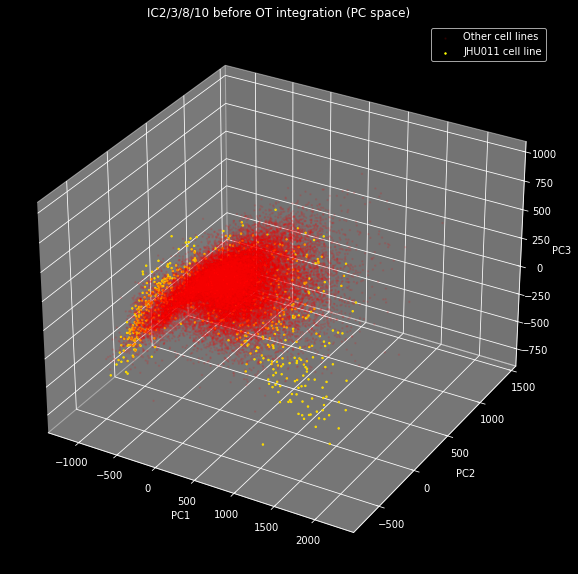

In [83]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(target_X)

X = np.vstack(Xs_before + [target_X])
X = pca.transform(X)
thr = len(X) - len(target_X)
ax.scatter(X[:thr,0], X[:thr,1], X[:thr,2], s=2, c='red', alpha=0.1, label='Other cell lines')
ax.scatter(X[thr:,0], X[thr:,1], X[thr:,2], s=2, c='yellow', alpha=1, label='JHU011 cell line')
plt.title('IC2/3/8/10 before OT integration (PC space)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.savefig('200cl_before.png')

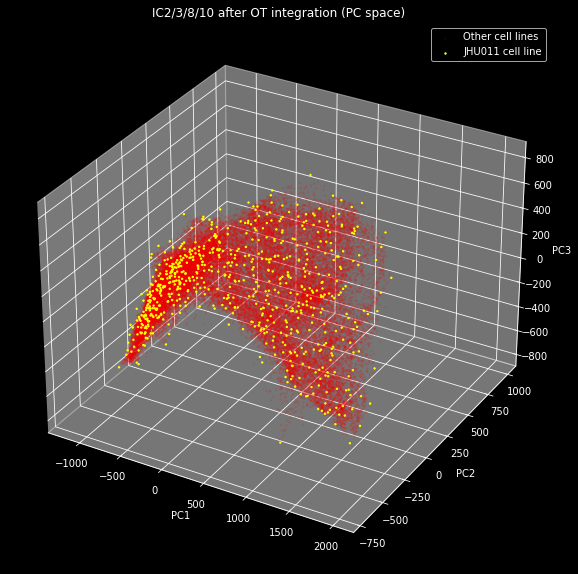

In [84]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(target_X)

X = np.vstack(Xs_raw + [target_X])
X = pca.transform(X)
thr = len(X) - len(target_X)
ax.scatter(X[:thr,0], X[:thr,1], X[:thr,2], s=2, c='red', alpha=0.1, label='Other cell lines')
ax.scatter(X[thr:,0], X[thr:,1], X[thr:,2], s=2, c='yellow', alpha=1, label='JHU011 cell line')
plt.title('IC2/3/8/10 after OT integration (PC space)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.savefig('200cl_OTraw.png')

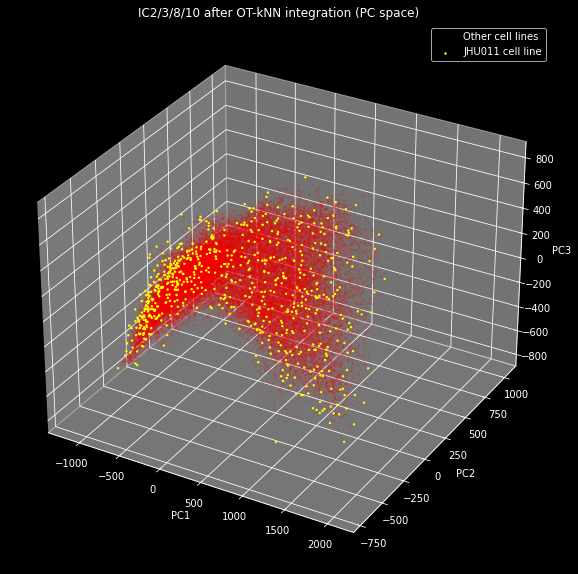

In [85]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(target_X)

X = np.vstack(Xs_regularized_nn + [target_X])
X = pca.transform(X)
thr = len(X) - len(target_X)
ax.scatter(X[:thr,0], X[:thr,1], X[:thr,2], s=2, c='red', alpha=0.1, label='Other cell lines')
ax.scatter(X[thr:,0], X[thr:,1], X[thr:,2], s=2, c='yellow', alpha=1, label='JHU011 cell line')
plt.title('IC2/3/8/10 after OT-kNN integration (PC space)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.savefig('200cl_OTraw_knn.png')

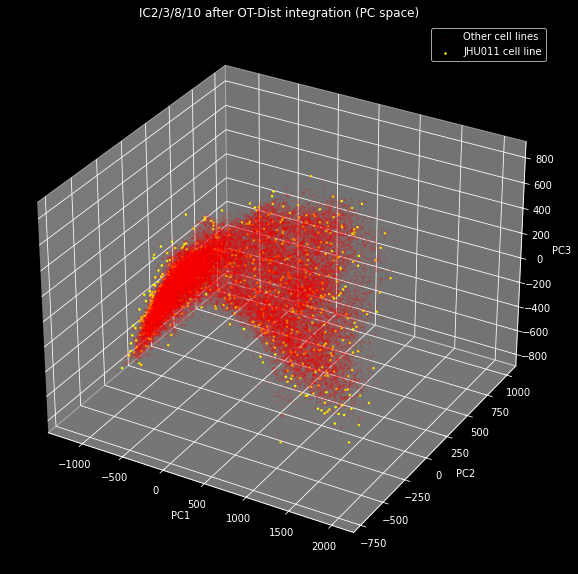

In [86]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(target_X)

X = np.vstack(Xs_regularized_d + [target_X])
X = pca.transform(X)
thr = len(X) - len(target_X)
ax.scatter(X[:thr,0], X[:thr,1], X[:thr,2], s=2, c='red', alpha=0.1, label='Other cell lines')
ax.scatter(X[thr:,0], X[thr:,1], X[thr:,2], s=2, c='yellow', alpha=1, label='JHU011 cell line')
plt.title('IC2/3/8/10 after OT-Dist integration (PC space)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.savefig('200cl_OTraw_dist.png')